In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  # draw face bounding box on image
  # for (x,y,w,h) in faces:
  #     img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg
'module' object is not callable


Detect

In [ ]:
!pip install ultralytics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from ultralytics import YOLO

In [ ]:
model = YOLO("yolov8n.pt")

100%|██████████| 6.23M/6.23M [00:00<00:00, 123MB/s]


In [ ]:
!unzip '/content/drive/MyDrive/food-detection-dataset.zip'

In [ ]:
model.train(data="/content/data.yaml", epochs=100,batch=10, plots=True )

Ultralytics YOLOv8.2.1 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data.yaml, epochs=100, time=None, patience=100, batch=10, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tr

100%|██████████| 755k/755k [00:00<00:00, 25.0MB/s]


Overriding model.yaml nc=80 with nc=49

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /content/train/labels... 2826 images, 3 backgrounds, 0 corrupt: 100%|██████████| 2826/2826 [00:01<00:00, 1886.62it/s]


train: New cache created: /content/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 276, len(boxes) = 11649. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/valid/labels... 274 images, 0 backgrounds, 0 corrupt: 100%|██████████| 274/274 [00:00<00:00, 1809.18it/s]

val: New cache created: /content/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 41, len(boxes) = 1185. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000189, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00046875), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.73G      1.547      4.605      1.751         35        640: 100%|██████████| 283/283 [01:16<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.40it/s]

                   all        274       1185     0.0118      0.285     0.0281     0.0158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       1.5G       1.55      3.918      1.774         65        640: 100%|██████████| 283/283 [01:13<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.46it/s]


                   all        274       1185      0.461     0.0969     0.0745     0.0442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       1.5G      1.567      3.475      1.805         39        640: 100%|██████████| 283/283 [01:10<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.19it/s]

                   all        274       1185      0.437      0.155      0.108     0.0625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.52G      1.547      3.215      1.774         23        640: 100%|██████████| 283/283 [01:10<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.11it/s]


                   all        274       1185      0.442      0.182      0.145     0.0943

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       1.5G       1.54      2.956      1.762         41        640: 100%|██████████| 283/283 [01:11<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.50it/s]

                   all        274       1185      0.528      0.161      0.171      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.52G      1.502      2.806      1.726         39        640: 100%|██████████| 283/283 [01:10<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.11it/s]

                   all        274       1185      0.472      0.209      0.206       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       1.5G      1.477      2.688      1.716         34        640: 100%|██████████| 283/283 [01:10<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.37it/s]


                   all        274       1185      0.473      0.227      0.225      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       1.5G      1.467      2.612      1.698         21        640: 100%|██████████| 283/283 [01:09<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.52it/s]


                   all        274       1185      0.448      0.252      0.233      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.51G      1.448      2.489       1.68         48        640: 100%|██████████| 283/283 [01:13<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.85it/s]


                   all        274       1185      0.444      0.272      0.243      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       1.5G      1.429      2.401      1.664         39        640: 100%|██████████| 283/283 [01:09<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.37it/s]

                   all        274       1185      0.473      0.265      0.262      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       1.5G      1.422      2.315      1.651         34        640: 100%|██████████| 283/283 [01:10<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.36it/s]


                   all        274       1185      0.496      0.265      0.257      0.155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.52G      1.397      2.267      1.638         38        640: 100%|██████████| 283/283 [01:09<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]


                   all        274       1185      0.413       0.27      0.256      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.52G      1.398      2.191      1.626         69        640: 100%|██████████| 283/283 [01:13<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]


                   all        274       1185      0.467      0.309      0.286      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       1.5G       1.38       2.13      1.609         59        640: 100%|██████████| 283/283 [01:09<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.18it/s]


                   all        274       1185      0.426      0.315      0.307      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.52G       1.37      2.085        1.6         54        640: 100%|██████████| 283/283 [01:09<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


                   all        274       1185       0.47      0.258      0.288      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.51G      1.352      2.037      1.595         31        640: 100%|██████████| 283/283 [01:10<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.19it/s]

                   all        274       1185      0.481      0.306      0.295      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       1.5G      1.338      1.975      1.577         39        640: 100%|██████████| 283/283 [01:10<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.52it/s]


                   all        274       1185      0.444      0.316      0.298      0.184

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.52G      1.352       1.95      1.579         58        640: 100%|██████████| 283/283 [01:09<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]

                   all        274       1185        0.5      0.272      0.301      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       1.5G      1.337      1.902      1.572         47        640: 100%|██████████| 283/283 [01:09<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.46it/s]

                   all        274       1185      0.555      0.272      0.309      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.52G      1.319      1.887      1.559         39        640: 100%|██████████| 283/283 [01:13<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]


                   all        274       1185      0.472      0.335      0.295      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       1.5G      1.323      1.831      1.555         46        640: 100%|██████████| 283/283 [01:08<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.38it/s]


                   all        274       1185      0.529      0.318      0.329      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100       1.5G      1.305      1.806      1.539         47        640: 100%|██████████| 283/283 [01:08<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.24it/s]


                   all        274       1185      0.526      0.306      0.326      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.51G      1.291      1.735      1.523         59        640: 100%|██████████| 283/283 [01:09<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.48it/s]


                   all        274       1185      0.434      0.341      0.329      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.51G      1.303      1.785      1.544         43        640: 100%|██████████| 283/283 [01:11<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]


                   all        274       1185      0.447      0.348      0.317        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.51G      1.299      1.703      1.526         33        640: 100%|██████████| 283/283 [01:08<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.80it/s]

                   all        274       1185      0.393      0.308       0.31      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       1.5G      1.277       1.68      1.514         66        640: 100%|██████████| 283/283 [01:07<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.44it/s]

                   all        274       1185      0.368      0.376      0.318      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.52G      1.277      1.645      1.504         52        640: 100%|██████████| 283/283 [01:08<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.43it/s]

                   all        274       1185      0.449      0.309      0.308       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       1.5G      1.277      1.634      1.506         54        640: 100%|██████████| 283/283 [01:11<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]


                   all        274       1185      0.479      0.296      0.321      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.52G      1.272       1.61      1.504         52        640: 100%|██████████| 283/283 [01:08<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.21it/s]

                   all        274       1185      0.452      0.326      0.317      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       1.5G      1.255       1.57      1.497         58        640: 100%|██████████| 283/283 [01:08<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.19it/s]


                   all        274       1185      0.423      0.339      0.314      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.52G      1.252      1.566      1.492         25        640: 100%|██████████| 283/283 [01:10<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]


                   all        274       1185      0.519      0.347      0.346      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.52G      1.249      1.548      1.487         45        640: 100%|██████████| 283/283 [01:10<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.65it/s]

                   all        274       1185      0.486      0.329      0.349      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       1.5G      1.236      1.519      1.482         64        640: 100%|██████████| 283/283 [01:08<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.46it/s]

                   all        274       1185      0.388      0.364      0.336      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100       1.5G      1.226      1.496      1.465         34        640: 100%|██████████| 283/283 [01:09<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


                   all        274       1185      0.378      0.349      0.335      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       1.5G      1.234      1.486      1.471         30        640: 100%|██████████| 283/283 [01:11<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.30it/s]


                   all        274       1185        0.4      0.354       0.33      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.51G      1.233      1.457      1.463         65        640: 100%|██████████| 283/283 [01:08<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.85it/s]


                   all        274       1185       0.49      0.331      0.332      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.51G       1.21      1.439      1.458         54        640: 100%|██████████| 283/283 [01:08<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


                   all        274       1185      0.547      0.323      0.341      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.51G      1.208      1.415       1.45         28        640: 100%|██████████| 283/283 [01:08<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.39it/s]


                   all        274       1185        0.5      0.343      0.336      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.52G        1.2      1.408      1.444         30        640: 100%|██████████| 283/283 [01:12<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.58it/s]


                   all        274       1185      0.491      0.328      0.343      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       1.5G      1.199      1.398      1.436         62        640: 100%|██████████| 283/283 [01:08<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.52it/s]


                   all        274       1185      0.526      0.307      0.333      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100       1.5G      1.196      1.365       1.43         48        640: 100%|██████████| 283/283 [01:08<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]


                   all        274       1185       0.44      0.341      0.328      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.52G       1.18      1.341      1.414         66        640: 100%|██████████| 283/283 [01:09<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.62it/s]


                   all        274       1185      0.463      0.313      0.336      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       1.5G      1.182      1.361      1.431         27        640: 100%|██████████| 283/283 [01:10<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.39it/s]


                   all        274       1185      0.452      0.333      0.346      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.51G      1.171       1.33      1.424         61        640: 100%|██████████| 283/283 [01:09<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]

                   all        274       1185      0.438       0.36      0.342      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.52G      1.186      1.322      1.423         55        640: 100%|██████████| 283/283 [01:09<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.33it/s]

                   all        274       1185      0.368      0.346      0.339      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.51G      1.169      1.304      1.417         47        640: 100%|██████████| 283/283 [01:12<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]


                   all        274       1185      0.382      0.357      0.337      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.52G      1.167      1.298      1.413         59        640: 100%|██████████| 283/283 [01:09<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.47it/s]

                   all        274       1185      0.539      0.331      0.342      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.51G      1.155      1.284       1.41         33        640: 100%|██████████| 283/283 [01:11<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.38it/s]


                   all        274       1185      0.447      0.335      0.344       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       1.5G      1.171      1.289      1.409         59        640: 100%|██████████| 283/283 [01:09<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]


                   all        274       1185      0.404      0.367      0.358      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.51G       1.16      1.281      1.406         50        640: 100%|██████████| 283/283 [01:10<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


                   all        274       1185       0.53      0.313      0.347      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.51G      1.151      1.254      1.401         42        640: 100%|██████████| 283/283 [01:08<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.60it/s]

                   all        274       1185      0.412      0.377      0.359      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.52G      1.149      1.229      1.393         30        640: 100%|██████████| 283/283 [01:08<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.25it/s]

                   all        274       1185      0.405       0.36      0.353      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       1.5G      1.138      1.234      1.393         24        640: 100%|██████████| 283/283 [01:10<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]


                   all        274       1185      0.441      0.367      0.355      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.51G      1.136      1.231      1.386         46        640: 100%|██████████| 283/283 [01:10<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.25it/s]


                   all        274       1185      0.403      0.373      0.365      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.51G       1.14      1.215      1.378         36        640: 100%|██████████| 283/283 [01:09<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.78it/s]


                   all        274       1185       0.45      0.354      0.369       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.51G       1.12        1.2      1.377         20        640: 100%|██████████| 283/283 [01:11<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.39it/s]


                   all        274       1185      0.483      0.349      0.363      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       1.5G      1.121      1.181      1.371         53        640: 100%|██████████| 283/283 [01:14<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]


                   all        274       1185      0.434      0.363      0.366      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.51G      1.137      1.186      1.378         39        640: 100%|██████████| 283/283 [01:09<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.45it/s]


                   all        274       1185      0.418      0.352      0.356       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100       1.5G      1.112      1.179       1.37         22        640: 100%|██████████| 283/283 [01:09<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.47it/s]

                   all        274       1185      0.555      0.309      0.356      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       1.5G      1.113      1.159      1.365         53        640: 100%|██████████| 283/283 [01:11<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


                   all        274       1185      0.582      0.315      0.369       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       1.5G      1.106      1.161      1.361         35        640: 100%|██████████| 283/283 [01:11<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]


                   all        274       1185      0.459       0.35      0.344      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       1.5G      1.103      1.137      1.351         54        640: 100%|██████████| 283/283 [01:10<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.21it/s]


                   all        274       1185      0.478      0.345      0.373       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.51G      1.092      1.129      1.351         43        640: 100%|██████████| 283/283 [01:10<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


                   all        274       1185      0.483      0.317      0.347      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       1.5G      1.093      1.131      1.347         41        640: 100%|██████████| 283/283 [01:13<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.75it/s]


                   all        274       1185      0.494       0.33      0.355      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.52G      1.088      1.127       1.35         25        640: 100%|██████████| 283/283 [01:10<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.08it/s]

                   all        274       1185      0.443      0.358      0.363      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       1.5G      1.089       1.11      1.344         39        640: 100%|██████████| 283/283 [01:10<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.21it/s]


                   all        274       1185       0.44      0.365      0.352       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.51G      1.081      1.112      1.342         45        640: 100%|██████████| 283/283 [01:10<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.33it/s]

                   all        274       1185      0.517      0.355      0.368       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       1.5G      1.084      1.106      1.342         50        640: 100%|██████████| 283/283 [01:12<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.58it/s]


                   all        274       1185       0.42      0.361      0.364      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.51G      1.066      1.097      1.333         47        640: 100%|██████████| 283/283 [01:10<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]

                   all        274       1185      0.441      0.353      0.361      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.52G      1.083      1.086      1.339         60        640: 100%|██████████| 283/283 [01:10<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.58it/s]

                   all        274       1185      0.431      0.378      0.377      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       1.5G      1.077      1.078      1.339         46        640: 100%|██████████| 283/283 [01:13<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.41it/s]


                   all        274       1185      0.435      0.365      0.367      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.51G      1.069       1.08      1.333         69        640: 100%|██████████| 283/283 [01:10<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]


                   all        274       1185      0.573       0.33      0.368      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.51G      1.068      1.073      1.328         33        640: 100%|██████████| 283/283 [01:10<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.28it/s]


                   all        274       1185      0.433      0.394       0.38      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.51G      1.066      1.065       1.33         32        640: 100%|██████████| 283/283 [01:10<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.09it/s]


                   all        274       1185      0.529      0.344      0.362      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       1.5G      1.061      1.059      1.322         51        640: 100%|██████████| 283/283 [01:13<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.03it/s]


                   all        274       1185      0.513      0.359      0.378      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.52G      1.055      1.062       1.32         80        640: 100%|██████████| 283/283 [01:11<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


                   all        274       1185      0.504      0.318      0.362      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.51G      1.054      1.047      1.316         47        640: 100%|██████████| 283/283 [01:11<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.36it/s]

                   all        274       1185      0.484       0.34      0.372       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.52G      1.045      1.029      1.306         33        640: 100%|██████████| 283/283 [01:14<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]


                   all        274       1185      0.553      0.337      0.375      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.51G      1.046      1.041      1.318         56        640: 100%|██████████| 283/283 [01:10<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.18it/s]

                   all        274       1185      0.497      0.336      0.368      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.51G      1.063      1.047      1.328         47        640: 100%|██████████| 283/283 [01:10<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.32it/s]


                   all        274       1185      0.624      0.323      0.369      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100       1.5G      1.039      1.036      1.311         41        640: 100%|██████████| 283/283 [01:12<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.74it/s]

                   all        274       1185      0.518      0.346      0.374      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.52G      1.055      1.053       1.32         42        640: 100%|██████████| 283/283 [01:13<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]

                   all        274       1185      0.454      0.388      0.372      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.51G      1.048      1.026      1.311         38        640: 100%|██████████| 283/283 [01:10<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.84it/s]

                   all        274       1185       0.51      0.331      0.364      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.52G       1.04      1.004        1.3         70        640: 100%|██████████| 283/283 [01:11<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]


                   all        274       1185       0.51      0.363       0.37       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       1.5G      1.025      1.014      1.301         55        640: 100%|██████████| 283/283 [01:13<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.34it/s]


                   all        274       1185      0.563      0.324      0.371      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       1.5G      1.031      1.012      1.299         38        640: 100%|██████████| 283/283 [01:11<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.40it/s]


                   all        274       1185      0.556      0.325      0.368      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.51G      1.021     0.9972      1.293         51        640: 100%|██████████| 283/283 [01:10<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.48it/s]


                   all        274       1185      0.507      0.344      0.363       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.52G      1.026      0.995      1.293         29        640: 100%|██████████| 283/283 [01:12<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.07it/s]


                   all        274       1185      0.486      0.355      0.365      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       1.5G      1.033     0.9976      1.298         44        640: 100%|██████████| 283/283 [01:13<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.35it/s]


                   all        274       1185      0.526      0.343      0.368      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.52G       1.02      1.004      1.295         47        640: 100%|██████████| 283/283 [01:11<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.96it/s]

                   all        274       1185      0.534      0.348      0.374      0.233


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.63G      1.011     0.9292      1.334         16        640: 100%|██████████| 283/283 [01:09<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.41it/s]


                   all        274       1185      0.444      0.366      0.356      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       1.5G     0.9907     0.8966      1.328         16        640: 100%|██████████| 283/283 [01:10<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.30it/s]


                   all        274       1185      0.443      0.372      0.365      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       1.5G     0.9849     0.8837      1.321         40        640: 100%|██████████| 283/283 [01:07<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]


                   all        274       1185      0.506      0.353      0.358      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.51G      0.976     0.8611      1.315         18        640: 100%|██████████| 283/283 [01:07<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]


                   all        274       1185      0.491      0.356      0.363      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100       1.5G     0.9682     0.8622       1.31         12        640: 100%|██████████| 283/283 [01:08<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


                   all        274       1185      0.485      0.356      0.365      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       1.5G      0.962     0.8364        1.3         27        640: 100%|██████████| 283/283 [01:08<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.49it/s]


                   all        274       1185      0.485      0.339      0.361      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       1.5G     0.9676     0.8399      1.307         25        640: 100%|██████████| 283/283 [01:05<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.13it/s]


                   all        274       1185      0.423      0.361      0.366      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.51G     0.9494     0.8306      1.294         10        640: 100%|██████████| 283/283 [01:06<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.83it/s]


                   all        274       1185      0.553      0.323      0.367      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       1.5G      0.945     0.8199      1.288         19        640: 100%|██████████| 283/283 [01:10<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.50it/s]


                   all        274       1185      0.511      0.344      0.367      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       1.5G     0.9558     0.8294      1.303         18        640: 100%|██████████| 283/283 [01:07<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]

                   all        274       1185      0.498      0.359      0.367      0.234



100 epochs completed in 2.080 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.1 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3015203 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.83it/s]


                   all        274       1185      0.493      0.331      0.372       0.24
               banh_mi        274         53      0.522      0.321      0.336        0.2
             bo_phomai        274          6      0.781      0.605      0.685       0.37
                   bun        274         11      0.879      0.455      0.678      0.419
              bun_nuoc        274          6      0.604      0.833      0.869      0.741
                    ca        274         17      0.173      0.176     0.0961     0.0619
               ca_chua        274         20          0          0     0.0711     0.0245
               ca_phao        274          5      0.387        0.4      0.376      0.242
                ca_rot        274         48      0.262      0.125       0.13     0.0664
                   cam        274         35      0.549      0.343       0.36      0.235
                  canh        274         27      0.593      0.778      0.706      0.409
                   co

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78d423b96800>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,

In [ ]:
# Assume model là biến chứa mô hình của bạn
model.save('/content/drive/My Drive/my_model')  # Không có đuôi file

In [ ]:
results = model.predict("/content/photo.jpg")


image 1/1 /content/photo.jpg: 480x640 1 com, 1 mi, 1 rau, 1 thit, 111.8ms
Speed: 2.5ms preprocess, 111.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


In [ ]:
result = results[0]

In [ ]:
box = result.boxes[0]

In [ ]:
for box in result.boxes:
  class_id = result.names[box.cls[0].item()]
  cords = box.xyxy[0].tolist()
  cords = [round(x) for x in cords]
  conf = round(box.conf[0].item(), 2)
  print("Object type:", class_id)
  print("Coordinates:", cords)
  print("Probability:", conf)
  print("---")

Object type: thit
Coordinates: [348, 27, 497, 156]
Probability: 0.93
---
Object type: rau
Coordinates: [0, 20, 172, 207]
Probability: 0.91
---
Object type: com
Coordinates: [162, 210, 367, 384]
Probability: 0.85
---
Object type: mi
Coordinates: [346, 27, 614, 249]
Probability: 0.39
---


In [ ]:
plot = results[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)

array([[[ 74,  67,  23],
        [ 74,  67,  23],
        [ 74,  67,  23],
        ...,
        [ 51,  56,  62],
        [ 51,  54,  61],
        [ 50,  53,  60]],

       [[ 91,  75,  35],
        [109,  85,  48],
        [111,  85,  49],
        ...,
        [ 51,  56,  62],
        [ 50,  55,  61],
        [ 50,  55,  61]],

       [[255, 157, 151],
        [255, 157, 151],
        [255, 157, 151],
        ...,
        [ 48,  55,  61],
        [ 48,  55,  61],
        [ 49,  56,  62]],

       ...,

       [[  2,   2,   2],
        [  2,   2,   2],
        [  2,   2,   2],
        ...,
        [  3,   3,   3],
        [  3,   3,   3],
        [  3,   3,   3]],

       [[  3,   3,   3],
        [  3,   3,   3],
        [  2,   2,   2],
        ...,
        [  3,   3,   3],
        [  3,   3,   3],
        [  3,   3,   3]],

       [[  4,   4,   4],
        [  3,   3,   3],
        [  2,   2,   2],
        ...,
        [  3,   3,   3],
        [  3,   3,   3],
        [  3,   3,   3]]], dtype=uint8)
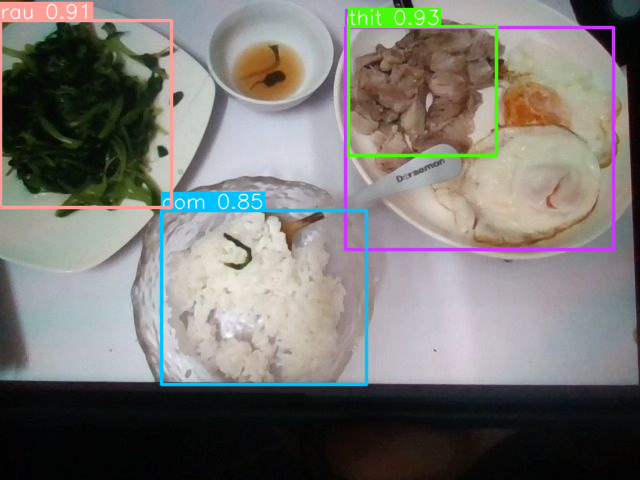

In [ ]:
plot

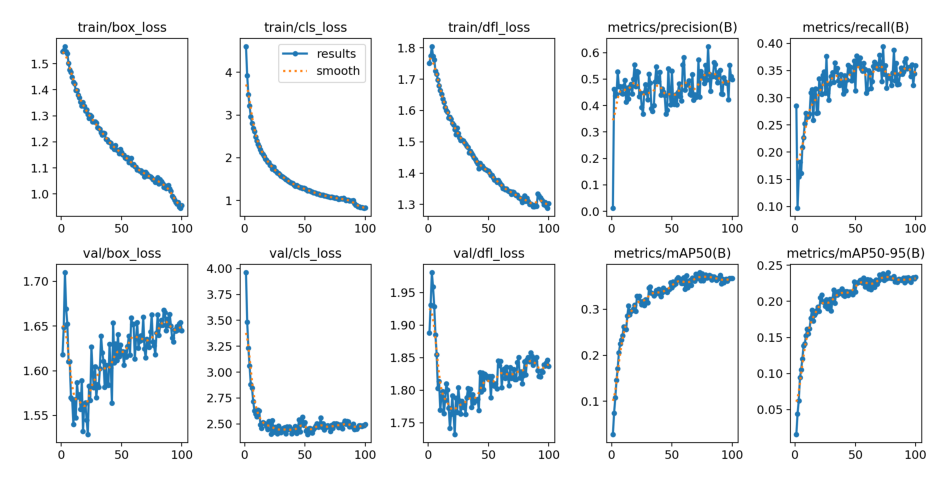

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
image_path = '/content/runs/detect/train/results.png'

    # Đọc hình ảnh
image = Image.open(image_path)

    # Hiển thị hình ảnh
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.axis('off')  # Tắt trục
plt.show()

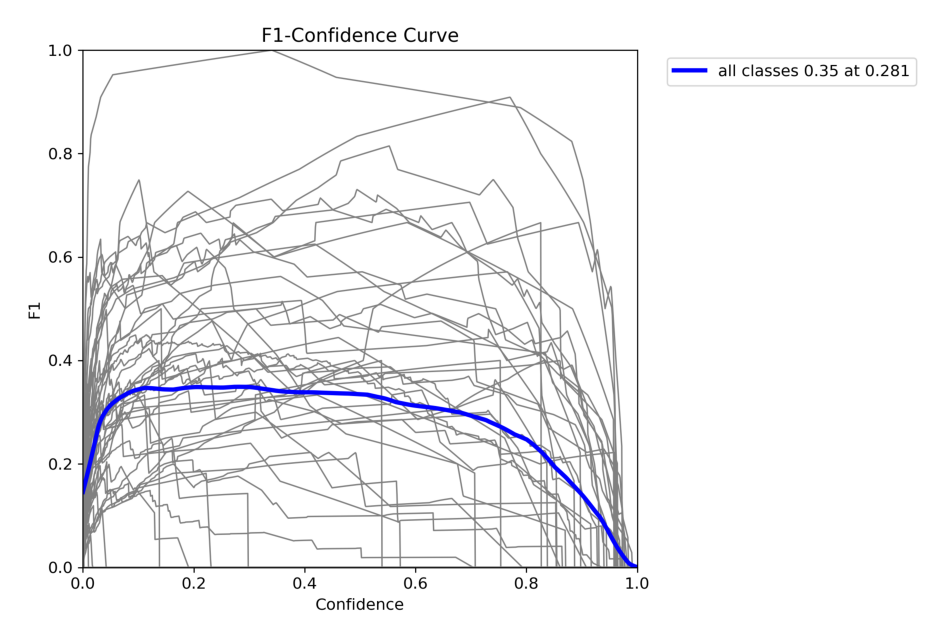

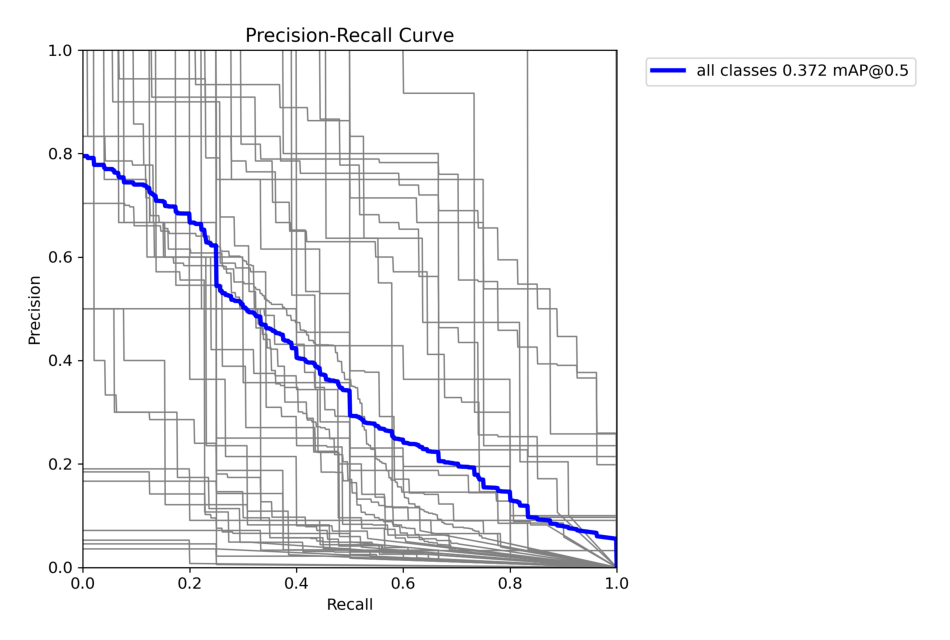

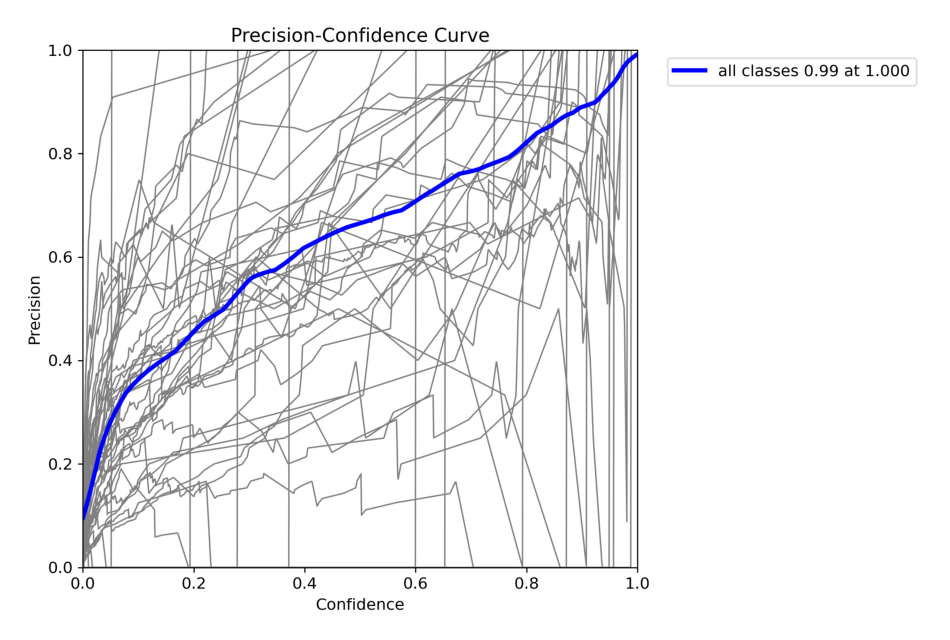

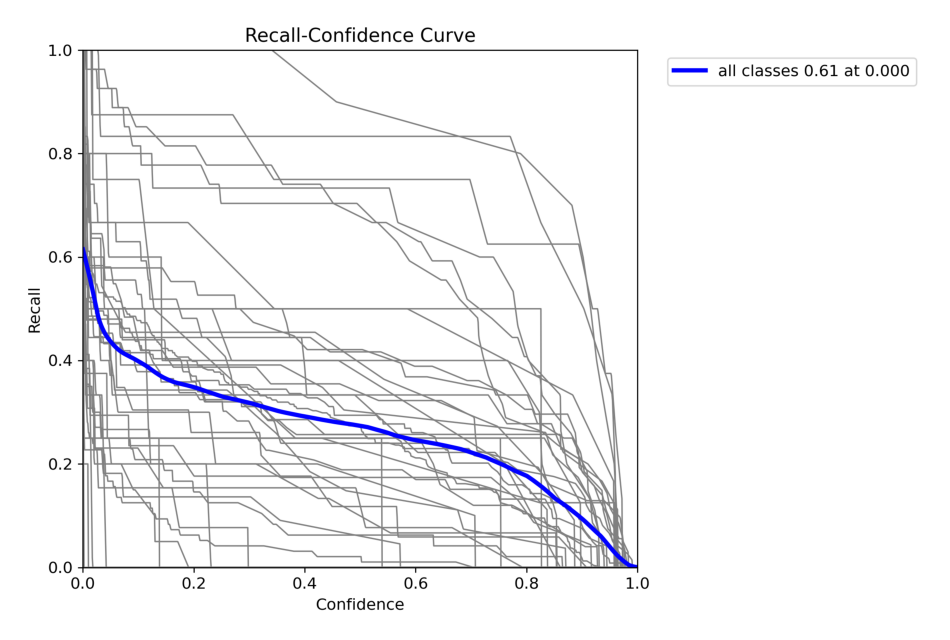

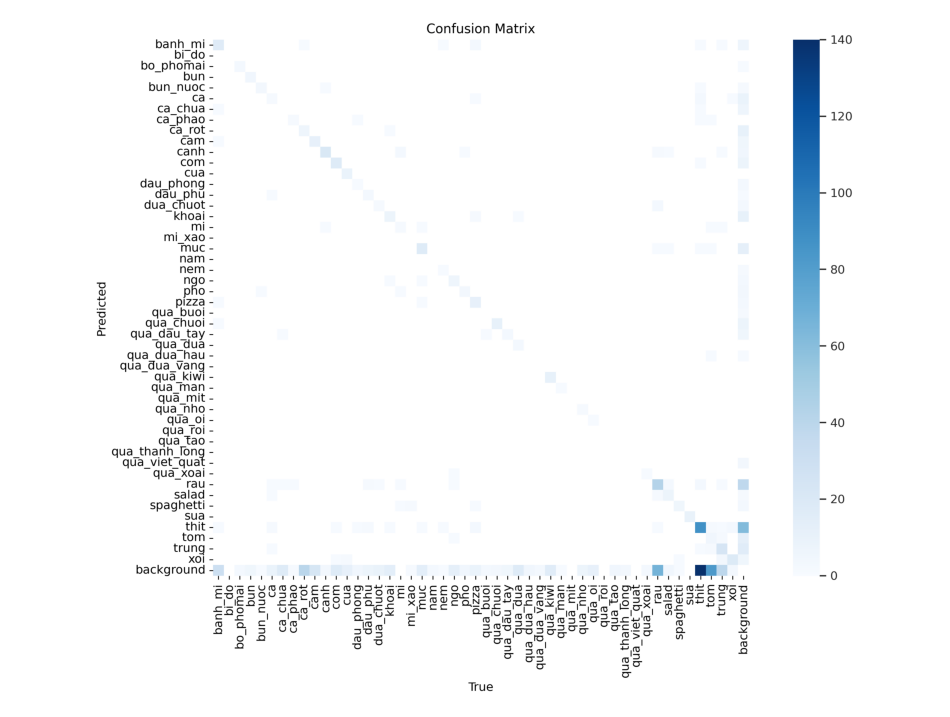

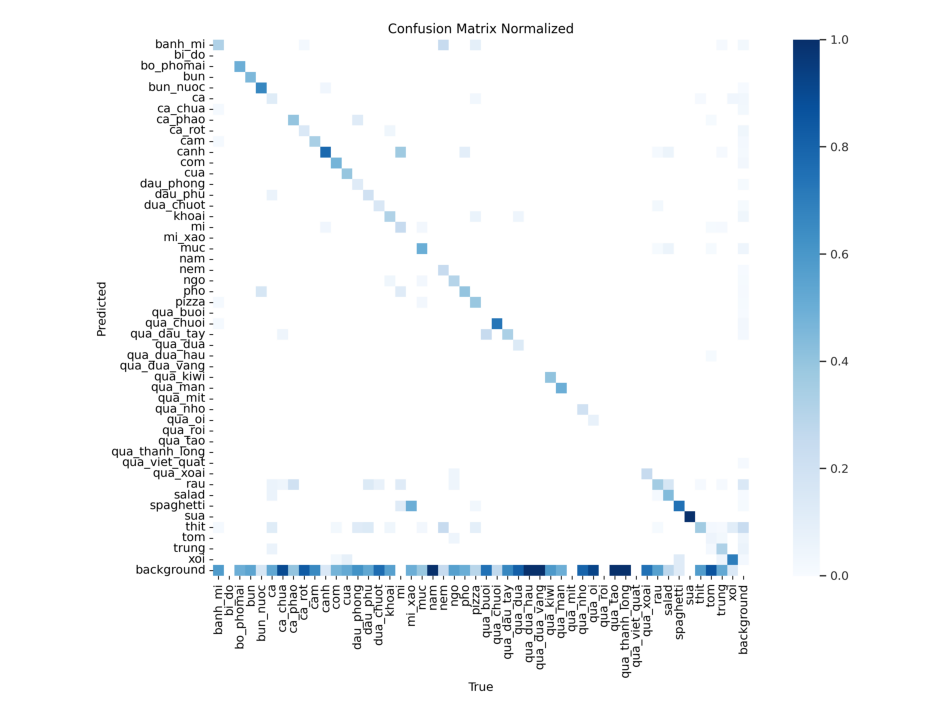

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Đường dẫn đến thư mục chứa các hình ảnh
folder_path = "/content/runs/detect/train"

# Lấy danh sách tên của tất cả các tệp trong thư mục
image_files = ['F1_curve.png','PR_curve.png','P_curve.png','R_curve.png', 'confusion_matrix.png','confusion_matrix_normalized.png']

# Hiển thị tất cả các hình ảnh
for image_file in image_files:
    # Tạo đường dẫn đầy đủ đến hình ảnh
    image_path = os.path.join(folder_path, image_file)

    # Đọc hình ảnh
    image = Image.open(image_path)

    # Hiển thị hình ảnh
    plt.figure(figsize=(12,12))
    plt.imshow(image)
    plt.axis('off')  # Tắt trục
    plt.show()


In [ ]:
metrics = model.val(data='/content/data.yaml')

Ultralytics YOLOv8.2.1 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/valid/labels.cache... 274 images, 0 backgrounds, 0 corrupt: 100%|██████████| 274/274 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 41, len(boxes) = 1185. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:07<00:00,  3.56it/s]


                   all        274       1185      0.479      0.345      0.372       0.24
               banh_mi        274         53      0.484      0.321      0.336        0.2
             bo_phomai        274          6       0.79      0.632      0.684      0.365
                   bun        274         11      0.857      0.455      0.676      0.419
              bun_nuoc        274          6      0.586      0.833      0.869      0.741
                    ca        274         17       0.16      0.176     0.0964      0.062
               ca_chua        274         20          0          0     0.0713     0.0246
               ca_phao        274          5      0.442      0.484       0.39      0.255
                ca_rot        274         48      0.245      0.128      0.131     0.0677
                   cam        274         35      0.534      0.343       0.36      0.235
                  canh        274         27      0.586      0.788      0.705      0.414
                   co

In [ ]:
metrics.results_dict

{'metrics/precision(B)': 0.47911563016379244,
 'metrics/recall(B)': 0.34452434629710016,
 'metrics/mAP50(B)': 0.37233215619524135,
 'metrics/mAP50-95(B)': 0.23967654226928597,
 'fitness': 0.2529421036618815}

In [ ]:
food_names = []
for box in result.boxes:
  class_id = result.names[box.cls[0].item()]
  food_names.append(class_id)

In [ ]:
food_names

['thit', 'rau', 'com', 'mi']

In [ ]:
nutrition_in_food = {
    'chat_dam':['thit','canh'],
    'chat_duong_bot':['com'],
    'chat_beo':[],
    'vitamin_khoangchat':['rau']
}

In [ ]:
shortage = []
for key, values in nutrition_in_food.items():
    found = False
    for value in values:
        if value in food_names:
            found = True
            break
    if not found:
        shortage.append(key)

if len(shortage) == 0:
  print("Bạn đã có một bữa ăn đủ chất")
else:
  print('Hãy bổ sung thêm các món ăn có chứa các chất dinh dưỡng sau để có một bữa ăn chất lượng hơn nhé:')
  print(shortage)

Hãy bổ sung thêm các món ăn có chứa các chất dinh dưỡng sau để có một bữa ăn chất lượng hơn nhé:
['chat_beo']


In [ ]:
model = '/content/drive/My Drive/my_model'